In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Camera calibration
**Source code**: `calibrate.py`

Camera calibration is accomplished by loading the chessboard images at `images/calibration` and running their grayscaled versions through `cv2.findChessboardCorners`. Corners (`imgpoints`) and chessboard coordinates (`objpoints`) for each image are calculated.

The camera is calibrated by passing the `imgpoints` and `objpoints` to `cv2.calibrateCamera` which returns the distortion coefficiants necessary to undistort an image. Distortion coefficiants are stored in a pickle file so they can be re-used throughout the project.

`cv2.undistort` can now be used to undistort any image taken with this camera.

## Undistorting an image

**Source code**: `distortion.py`

Below is a side-by-side of an undistorted image and its original.

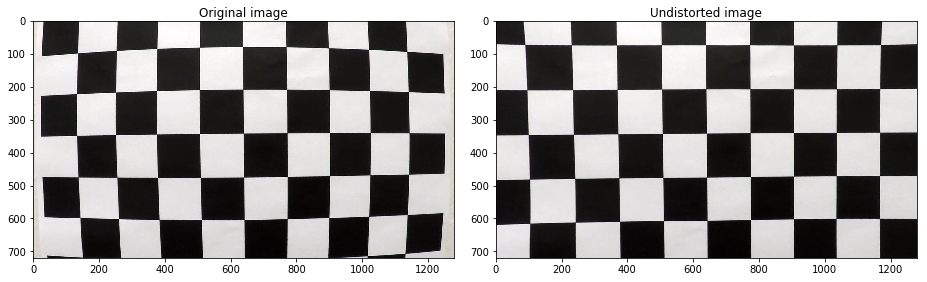

In [2]:
from distortion import Distortion
from image_helper import rgb_image
import matplotlib.pyplot as plt

distortion = Distortion("./calibration.pkl")
img = rgb_image("images/calibration/calibration01.jpg")
dst = distortion.undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
f.tight_layout()

ax1.set_title("Original image")
ax1.imshow(img)

ax2.set_title("Undistorted image")
ax2.imshow(dst);

plt.show();

## Transforming an image

**Source code**: `transformation.py`

Each image is transformed to a top-down view in order to clearly see the lane. Here is an example of a test image transformed to a top-down view.

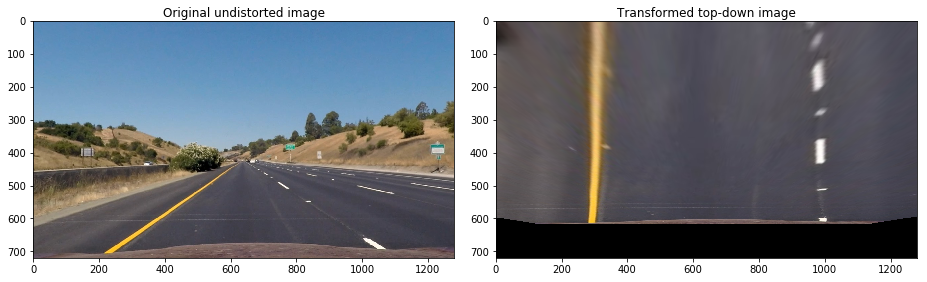

In [3]:
from distortion import Distortion
from image_helper import rgb_image
from transform import TopDownTransform
import matplotlib.pyplot as plt

distortion = Distortion("./calibration.pkl")
transform = TopDownTransform()
img = rgb_image("images/test/straight_lines1.jpg")
img = distortion.undistort(img)
dst = transform.transform_to_top_down(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
f.tight_layout()

ax1.set_title("Original undistorted image")
ax1.imshow(img)

ax2.set_title("Transformed top-down image")
ax2.imshow(dst);

plt.show();

## Thresholding an image
**Source code**: `thresholding.py`

After an image is undistorted and transformed to a top-down view, it goes through thresholding. Below is a side-by-side of points detected by the thresholding process.

After much trial and error, I settled on using the following thresholding techniques

### HLS - Saturation channel thresholding

After the converting the RGB image to the HLS colorspace, I singled out the saturation channel. The saturation channel is good at detecting yellow lines.

### RGB - Red channel thresholding

Singling out the red channel of the image is good for detecting the white lines.

### Sobel gradient thesholding in X direction

Using sobel gradient thresholding I was able to detect changes in horizontal direction

### Combining the thresholding techniques

I combine the three techniques unsing an simple `or`.

### Previous attempts

My previous attempts included sobel gradients in the vertical direction, using the magniture of the sobel gradient and using the direction of the sobel gradient. I was not getting good results with those so I scaled back and settled on these three techniques only.

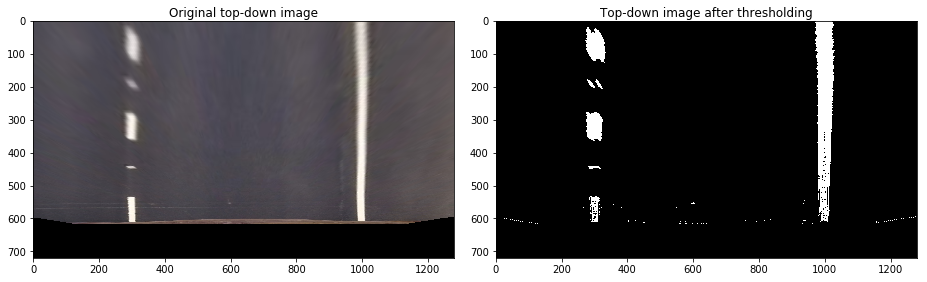

In [4]:
from distortion import Distortion
from image_helper import rgb_image
from transform import TopDownTransform
import matplotlib.pyplot as plt
import thresholding

distortion = Distortion("./calibration.pkl")
transform = TopDownTransform()
img = rgb_image("images/test/straight_lines2.jpg")
img = distortion.undistort(img)
img = transform.transform_to_top_down(img)
dst = thresholding.pipeline(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
f.tight_layout()

ax1.set_title("Original top-down image")
ax1.imshow(img)

ax2.set_title("Top-down image after thresholding")
ax2.imshow(dst, cmap="gray");

plt.show();

## Detecting lane lines
**Source code**: `detection.py`

Lane line detection is done using the sliding windows technique explained in the course. The sum of all the line points detect in the thresholding phase is taken for the bottom half of the image. This let's us detect where the two lane lines are approximately. Using this approximation, we then find all the nonzero values inside a window, and store those points as points for the lane line. We slide the window up, and repeat finding nonzero values. When the sliding window reaches the top of the image, we fit a parabola to the points that were detected. This polynomial can be used to calculate the lane line values at any point.

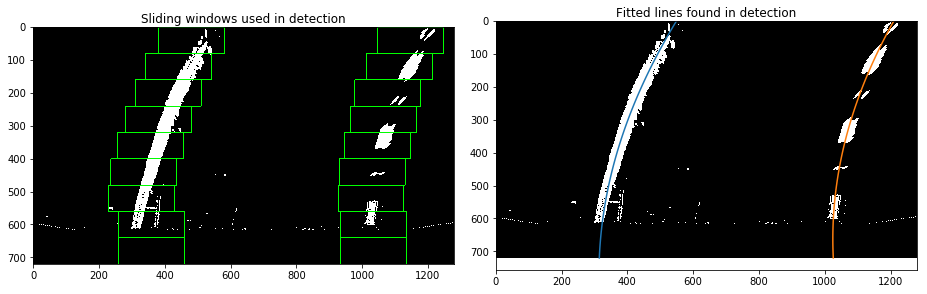

In [5]:
from distortion import Distortion
from image_helper import rgb_image
from transform import TopDownTransform
from detection import detect_lane_lines
import matplotlib.pyplot as plt
import numpy as np
import thresholding

distortion = Distortion("./calibration.pkl")
transform = TopDownTransform()

img = rgb_image("images/test/test3.jpg")
img = distortion.undistort(img)
img = transform.transform_to_top_down(img)
img = thresholding.pipeline(img)

lanes, out = detect_lane_lines(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
f.tight_layout()

ax1.set_title("Sliding windows used in detection")
ax1.imshow(out, cmap="gray")

ax2.set_title("Fitted lines found in detection")
ax2.imshow(img, cmap="gray");

# Left lane
left_p = np.poly1d(lanes.left.pixels.fit)
left_xp = np.linspace(0, 720, 100)
ax2.plot(left_p(left_xp), left_xp)

# Right lane
right_p = np.poly1d(lanes.right.pixels.fit)
right_xp = np.linspace(0, 720, 100)
ax2.plot(right_p(right_xp), right_xp)

plt.show();

## Lane curvature
**Source code**: `lane.py`

Lane curvature is determined using the following curvature formula

```python
fit = np.polyfit(xs, ys) # using the xs and ys found during detection
p   = np.poly1d(fit)     # polynomial helper function
p1  = np.polyder(p)      # first derivative of out polynomial
p2  = np.polyder(p, 2)   # second derivative of our polynomial

# y is the point at which you'd like to find the curvature
((1 + (p1(y)**2))**1.5) / np.absolute(p2(y))
```

These calculations are performed inside `lane.py`.

In the example below, you can see the image with a straight lane has a very large curvature radius, whereas the image with the lane that is curving rightward has a smaller curvature radius.

## Distance from center
**Source code**: `lanes.py`

Assuming the camera is mounted in the center of the car, the distance to the center of the lane can be calculated by find the difference from the center of the lanes, to the center of the image.

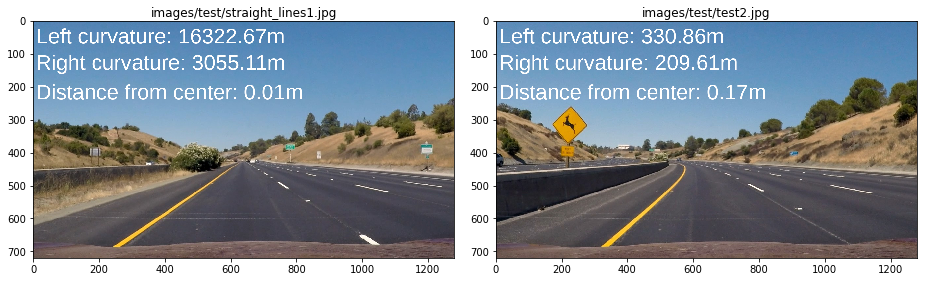

In [6]:
from distortion import Distortion
from image_helper import rgb_image
from transform import TopDownTransform
from detection import detect_lane_lines
from overlay import overlay_text
import matplotlib.pyplot as plt
import numpy as np
import thresholding

distortion = Distortion("./calibration.pkl")
transform = TopDownTransform()

def overlay_information(img, lanes):
    height, width, _ = img.shape
    
    left_curvature = lanes.left.meters.curvature(height)
    right_curvature = lanes.right.meters.curvature(height)
    distance_from_center = lanes.distance_from_center(center=(width/2, height))
    
    img = overlay_text(img, "Left curvature: {0:.2f}m".format(left_curvature), pos=(10, 10))
    img = overlay_text(img, "Right curvature: {0:.2f}m".format(right_curvature), pos=(10, 90))
    img = overlay_text(img, "Distance from center: {0:.2f}m".format(distance_from_center), pos=(10, 180))
    return img

def load_image_and_overlay_information(filepath, ax):
    img = rgb_image(filepath)
    dst = distortion.undistort(img)
    dst = transform.transform_to_top_down(dst)
    dst = thresholding.pipeline(dst)
    lanes, out = detect_lane_lines(dst)
    
    img = overlay_information(img, lanes)
    
    ax.set_title(filepath)
    ax.imshow(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
f.tight_layout()

load_image_and_overlay_information("images/test/straight_lines1.jpg", ax1)
load_image_and_overlay_information("images/test/test2.jpg", ax2)

plt.show();

## Pipeline on a single image
**Source code**: `pipeline.py`

The pipeline combines all the steps described above and performs them through a simple interface. Simply passing an image to the pipeline will undistort, transform to top-down, apply thresholding, detect lane lines and finally overlay the detected lane line and calculated lane line information. Below are two examples of the pipeline running through the process.

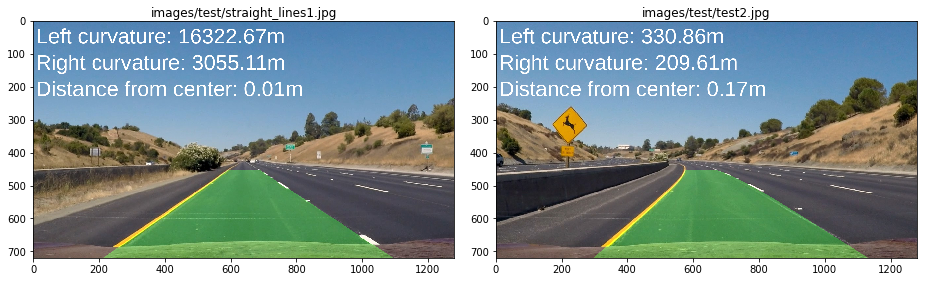

In [7]:
from pipeline import Pipeline
import matplotlib.pyplot as plt

def process_image(filepath, ax):
    pipeline = Pipeline()
    img = rgb_image(filepath)
    out = pipeline.process_image(img)
    ax.set_title(filepath)
    ax.imshow(out)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 10))
f.tight_layout()

process_image("images/test/straight_lines1.jpg", ax1)
process_image("images/test/test2.jpg", ax2)

plt.show();

## Pipeline on video
**Source code**: `convert_video.py`

The pipeline can easily be used on video. Using the MoviePY library, I run each image in the video through `pipeline.process_image` and produce a new video from the returned image.

Note: I was having trouble embedding the YouTube video into the Jupyter notebook. You watch the final video on YouTube, or in the repo at `output/project_video.mp4`

### Click to watch [Udacity - CarND - (Project 4) Advanced Lane Lines](https://youtu.be/lCxT2haxePo)